In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.stage2 import generate_2nd_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["2nd_stage"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['2nd_stage']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-15 03:42:51.489377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 03:42:51.619653: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-15 03:42:52.091901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_083


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")
train, features = generate_2nd_stage_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [08:01<00:00,  1.74s/it]


,anglez_diff_abs,anglez_diff_abs_rolling_max_10,anglez_diff_abs_rolling_max_100,anglez_diff_abs_rolling_max_1000,anglez_diff_abs_rolling_max_50,anglez_diff_abs_rolling_mean_10,anglez_diff_abs_rolling_mean_100,anglez_diff_abs_rolling_mean_1000,anglez_diff_abs_rolling_mean_50,anglez_diff_abs_rolling_median_10,...,anglez_mean_rolling_median_1000_shift_416,enmo_mean_rolling_median_1000_shift_416,anglez_rolling_square_mean_1000_shift_416,enmo_rolling_square_mean_1000_shift_416,anglez_diff_abs_rolling_square_mean_1000_shift_416,enmo_diff_abs_rolling_square_mean_1000_shift_416,anglez_mean_rolling_square_mean_1000_shift_416,enmo_mean_rolling_square_mean_1000_shift_416,reduce_step,fold
283,16.702658,38.064583,51.115900,84.6226,51.115900,15.962638,11.263916,8.043460,12.792510,14.257165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6803,3
284,7.195825,28.564683,51.115900,84.6226,51.115900,8.541195,12.527601,7.737612,12.364961,6.165692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6827,3
285,16.351179,34.583987,51.115900,84.6226,40.295400,15.494380,12.499973,7.288104,12.204054,14.248077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6851,3
286,10.855896,32.284983,42.890471,84.6226,38.495083,10.967216,12.269771,6.938846,12.743385,6.737581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6875,3
287,11.523954,27.963821,43.971200,84.6226,41.090162,12.171813,13.303702,6.618652,12.236429,10.896129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6899,3


(877617, 1382)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG["2nd_stage"]["xgboost"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81948
[100]	eval-rmse:1.19856
[200]	eval-rmse:1.03520
[300]	eval-rmse:0.98911
[400]	eval-rmse:0.97146
[500]	eval-rmse:0.96367
[600]	eval-rmse:0.95894
[700]	eval-rmse:0.95541
[800]	eval-rmse:0.95314
[900]	eval-rmse:0.95142
[1000]	eval-rmse:0.95028
[1100]	eval-rmse:0.94928
[1200]	eval-rmse:0.94859
[1300]	eval-rmse:0.94805
[1400]	eval-rmse:0.94737
[1500]	eval-rmse:0.94703
[1600]	eval-rmse:0.94681
[1700]	eval-rmse:0.94647
[1800]	eval-rmse:0.94612
[1900]	eval-rmse:0.94581
[2000]	eval-rmse:0.94557
[2100]	eval-rmse:0.94548
[2200]	eval-rmse:0.94526
[2300]	eval-rmse:0.94510
[2400]	eval-rmse:0.94470
[2500]	eval-rmse:0.94451
[2600]	eval-rmse:0.94433
[2700]	eval-rmse:0.94400
[2800]	eval-rmse:0.94373
[2900]	eval-rmse:0.94336
[3000]	eval-rmse:0.94302
[3100]	eval-rmse:0.94286
[3200]	eval-rmse:0.94276
[3300]	eval-rmse:0.94267
[3400]	eval-rmse:0.94270
[3411]	eval-rmse:0.94269


 20%|██        | 1/5 [03:33<14:15, 213.78s/it]

== fold 1 ==
[0]	eval-rmse:1.70257
[100]	eval-rmse:1.14786
[200]	eval-rmse:1.00791
[300]	eval-rmse:0.96342
[400]	eval-rmse:0.94170
[500]	eval-rmse:0.93001
[600]	eval-rmse:0.92366
[700]	eval-rmse:0.91932
[800]	eval-rmse:0.91588
[900]	eval-rmse:0.91338
[1000]	eval-rmse:0.91149
[1100]	eval-rmse:0.90998
[1200]	eval-rmse:0.90849
[1300]	eval-rmse:0.90774
[1400]	eval-rmse:0.90715
[1500]	eval-rmse:0.90657
[1600]	eval-rmse:0.90605
[1700]	eval-rmse:0.90549
[1800]	eval-rmse:0.90517
[1900]	eval-rmse:0.90465
[2000]	eval-rmse:0.90435
[2100]	eval-rmse:0.90412
[2200]	eval-rmse:0.90386
[2300]	eval-rmse:0.90374
[2400]	eval-rmse:0.90348
[2500]	eval-rmse:0.90332
[2600]	eval-rmse:0.90299
[2700]	eval-rmse:0.90283
[2800]	eval-rmse:0.90269
[2900]	eval-rmse:0.90264
[3000]	eval-rmse:0.90243
[3100]	eval-rmse:0.90224
[3200]	eval-rmse:0.90214
[3300]	eval-rmse:0.90210
[3384]	eval-rmse:0.90217


 40%|████      | 2/5 [07:08<10:42, 214.25s/it]

== fold 2 ==
[0]	eval-rmse:1.74065
[100]	eval-rmse:1.16478
[200]	eval-rmse:1.02433
[300]	eval-rmse:0.98318
[400]	eval-rmse:0.96664
[500]	eval-rmse:0.96018
[600]	eval-rmse:0.95614
[700]	eval-rmse:0.95269
[800]	eval-rmse:0.94998
[900]	eval-rmse:0.94808
[1000]	eval-rmse:0.94684
[1100]	eval-rmse:0.94591
[1200]	eval-rmse:0.94528
[1300]	eval-rmse:0.94502
[1400]	eval-rmse:0.94461
[1500]	eval-rmse:0.94445
[1600]	eval-rmse:0.94433
[1700]	eval-rmse:0.94408
[1800]	eval-rmse:0.94382
[1900]	eval-rmse:0.94383
[1928]	eval-rmse:0.94379


 60%|██████    | 3/5 [09:15<05:49, 174.68s/it]

== fold 3 ==
[0]	eval-rmse:1.71352
[100]	eval-rmse:1.12168
[200]	eval-rmse:0.97021
[300]	eval-rmse:0.92630
[400]	eval-rmse:0.91003
[500]	eval-rmse:0.90111
[600]	eval-rmse:0.89731
[700]	eval-rmse:0.89508
[800]	eval-rmse:0.89329
[900]	eval-rmse:0.89184
[1000]	eval-rmse:0.89090
[1100]	eval-rmse:0.89021
[1200]	eval-rmse:0.88936
[1300]	eval-rmse:0.88844
[1400]	eval-rmse:0.88770
[1500]	eval-rmse:0.88741
[1600]	eval-rmse:0.88701
[1700]	eval-rmse:0.88697
[1800]	eval-rmse:0.88685
[1900]	eval-rmse:0.88670
[2000]	eval-rmse:0.88670
[2017]	eval-rmse:0.88661


 80%|████████  | 4/5 [11:25<02:36, 156.96s/it]

== fold 4 ==
[0]	eval-rmse:1.79045
[100]	eval-rmse:1.18209
[200]	eval-rmse:1.02618
[300]	eval-rmse:0.98237
[400]	eval-rmse:0.96696
[500]	eval-rmse:0.96098
[600]	eval-rmse:0.95874
[700]	eval-rmse:0.95728
[800]	eval-rmse:0.95616
[900]	eval-rmse:0.95523
[1000]	eval-rmse:0.95439
[1100]	eval-rmse:0.95406
[1200]	eval-rmse:0.95359
[1300]	eval-rmse:0.95350
[1339]	eval-rmse:0.95351


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81635
[100]	eval-rmse:1.20579
[200]	eval-rmse:1.03167
[300]	eval-rmse:0.97773
[400]	eval-rmse:0.95981
[500]	eval-rmse:0.95206
[600]	eval-rmse:0.94900
[700]	eval-rmse:0.94700
[800]	eval-rmse:0.94560
[900]	eval-rmse:0.94447
[1000]	eval-rmse:0.94378
[1100]	eval-rmse:0.94293
[1200]	eval-rmse:0.94220
[1300]	eval-rmse:0.94148
[1400]	eval-rmse:0.94105
[1500]	eval-rmse:0.94070
[1600]	eval-rmse:0.94063
[1700]	eval-rmse:0.94030
[1800]	eval-rmse:0.94000
[1900]	eval-rmse:0.93936
[2000]	eval-rmse:0.93926
[2100]	eval-rmse:0.93898
[2200]	eval-rmse:0.93860
[2300]	eval-rmse:0.93826
[2400]	eval-rmse:0.93805
[2500]	eval-rmse:0.93790
[2600]	eval-rmse:0.93787
[2700]	eval-rmse:0.93766
[2800]	eval-rmse:0.93749
[2900]	eval-rmse:0.93734
[3000]	eval-rmse:0.93719
[3100]	eval-rmse:0.93720
[3142]	eval-rmse:0.93722


 20%|██        | 1/5 [03:22<13:28, 202.11s/it]

== fold 1 ==
[0]	eval-rmse:1.69853
[100]	eval-rmse:1.15489
[200]	eval-rmse:1.00821
[300]	eval-rmse:0.95759
[400]	eval-rmse:0.93797
[500]	eval-rmse:0.92636
[600]	eval-rmse:0.92191
[700]	eval-rmse:0.91883
[800]	eval-rmse:0.91699
[900]	eval-rmse:0.91601
[1000]	eval-rmse:0.91487
[1100]	eval-rmse:0.91385
[1200]	eval-rmse:0.91334
[1300]	eval-rmse:0.91225
[1400]	eval-rmse:0.91149
[1500]	eval-rmse:0.91093
[1600]	eval-rmse:0.91071
[1700]	eval-rmse:0.90966
[1800]	eval-rmse:0.90922
[1900]	eval-rmse:0.90917
[1992]	eval-rmse:0.90933


 40%|████      | 2/5 [05:38<08:10, 163.53s/it]

== fold 2 ==
[0]	eval-rmse:1.74252
[100]	eval-rmse:1.19416
[200]	eval-rmse:1.04320
[300]	eval-rmse:0.99144
[400]	eval-rmse:0.97229
[500]	eval-rmse:0.96381
[600]	eval-rmse:0.95925
[700]	eval-rmse:0.95634
[800]	eval-rmse:0.95452
[900]	eval-rmse:0.95364
[1000]	eval-rmse:0.95237
[1100]	eval-rmse:0.95188
[1200]	eval-rmse:0.95137
[1300]	eval-rmse:0.95103
[1400]	eval-rmse:0.95039
[1500]	eval-rmse:0.94991
[1600]	eval-rmse:0.94962
[1700]	eval-rmse:0.94926
[1800]	eval-rmse:0.94889
[1900]	eval-rmse:0.94844
[2000]	eval-rmse:0.94808
[2100]	eval-rmse:0.94776
[2200]	eval-rmse:0.94717
[2300]	eval-rmse:0.94676
[2400]	eval-rmse:0.94665
[2500]	eval-rmse:0.94650
[2600]	eval-rmse:0.94614
[2700]	eval-rmse:0.94580
[2800]	eval-rmse:0.94548
[2900]	eval-rmse:0.94519
[3000]	eval-rmse:0.94486
[3100]	eval-rmse:0.94468
[3200]	eval-rmse:0.94450
[3300]	eval-rmse:0.94438
[3400]	eval-rmse:0.94419
[3500]	eval-rmse:0.94410
[3526]	eval-rmse:0.94413


 60%|██████    | 3/5 [09:16<06:17, 188.56s/it]

== fold 3 ==
[0]	eval-rmse:1.70810
[100]	eval-rmse:1.15669
[200]	eval-rmse:1.01165
[300]	eval-rmse:0.96948
[400]	eval-rmse:0.95466
[500]	eval-rmse:0.94895
[600]	eval-rmse:0.94581
[700]	eval-rmse:0.94393
[800]	eval-rmse:0.94319
[900]	eval-rmse:0.94298
[1000]	eval-rmse:0.94293
[1039]	eval-rmse:0.94289


 80%|████████  | 4/5 [10:33<02:24, 144.34s/it]

== fold 4 ==
[0]	eval-rmse:1.78055
[100]	eval-rmse:1.19843
[200]	eval-rmse:1.04350
[300]	eval-rmse:0.99995
[400]	eval-rmse:0.98335
[500]	eval-rmse:0.97619
[600]	eval-rmse:0.97269
[700]	eval-rmse:0.97099
[800]	eval-rmse:0.96977
[900]	eval-rmse:0.96876
[1000]	eval-rmse:0.96810
[1100]	eval-rmse:0.96719
[1200]	eval-rmse:0.96671
[1300]	eval-rmse:0.96617
[1400]	eval-rmse:0.96548
[1500]	eval-rmse:0.96505
[1600]	eval-rmse:0.96479
[1700]	eval-rmse:0.96435
[1800]	eval-rmse:0.96403
[1900]	eval-rmse:0.96382
[2000]	eval-rmse:0.96334
[2100]	eval-rmse:0.96297
[2200]	eval-rmse:0.96277
[2300]	eval-rmse:0.96262
[2400]	eval-rmse:0.96234
[2500]	eval-rmse:0.96203
[2600]	eval-rmse:0.96198
[2700]	eval-rmse:0.96177
[2800]	eval-rmse:0.96165
[2900]	eval-rmse:0.96155
[3000]	eval-rmse:0.96155
[3034]	eval-rmse:0.96169


100%|██████████| 5/5 [13:50<00:00, 166.19s/it]


## Dynamic-Range NMS

<AxesSubplot: >

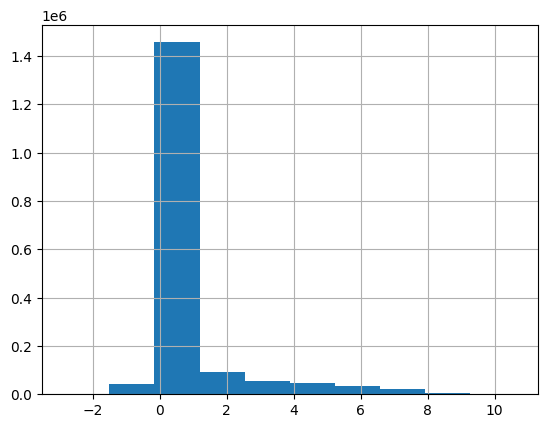

In [4]:
train["score"].hist()

In [5]:
train = train[train["score"] > 0.1]

In [6]:
from scipy.interpolate import interp1d
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np

score2range = interp1d([-100, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100], [0, 0, 12, 36, 60, 90, 120, 150, 180, 240, 300, 360, 360])
range2score = interp1d([0, 12, 36, 60, 90, 120, 150, 180, 240, 300, 360], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
score2range(1.5)

def process_group(df):
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    used = []
    used_scores = []
    reduce_rate = np.ones(df["step"].max() + 500)
    for _ in range(min(len(df), 1000)):
        df["reduced_score"] = df["score"] / reduce_rate[df["step"]]
        best_score = df["reduced_score"].max()
        best_idx = df["reduced_score"].idxmax()
        best_step = df.loc[best_idx, "step"]
        used.append(best_idx)
        used_scores.append(best_score)

        range_ = score2range(best_score)
        for r in range(1, int(range_)):
            reduce = range2score(range_ - r) + 1
            reduce_rate[best_step + r] = max(reduce_rate[best_step + r], reduce)
            if best_step - r >= 0:
                reduce_rate[best_step - r] = max(reduce_rate[best_step - r], reduce)
        reduce_rate[best_step] = 1e10
    df = df.iloc[used].copy()
    df["reduced_score"] = used_scores
    return df

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(process_group, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:15<00:00, 18.36it/s]


In [7]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7156


event   tolerance
onset   12           0.112619
        36           0.491082
        60           0.694314
        90           0.786472
        120          0.812832
        150          0.825178
        180          0.835209
        240          0.843938
        300          0.851071
        360          0.857187
wakeup  12           0.115144
        36           0.515757
        60           0.699397
        90           0.785854
        120          0.815031
        150          0.828753
        180          0.842102
        240          0.857039
        300          0.866826
        360          0.876596
dtype: float64